<a href="https://colab.research.google.com/github/Mitanosse/Getting-Things-Done-with-Pytorch/blob/master/Tutti_frutti.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## AMLDT_2022 
##Task: Image classification - DeepLearning




In questo approfondimento  è stato affrontato il task di "Image classification" utilizzando il dataset "Fruit 360" scaricabile da Kaggle (https://www.kaggle.com/moltean/fruits) e costruendo un modello deep learning. 
Da Kaggle si legge che il dataset è formato da circa 90'000 diverse immagini di frutti e ortaggi. Dal sito di Kaggle il dataset è già diviso in due cartelle: \
1) la prima con immagini destinate al Training con circa 67'000 immagini \
2) la seconda al Testing con circa 22'000 immagini. \
E' presente una classificazione in 131 categorie. Sono tutte immagini a risoluzione 100x100. \
**Nota sulle dimensioni del dataset**: \
Il dataset reperibile su Kaggle è in realtà molto più grande, dato che contiene anche tutte le immagini nella loro dimensione originale e in aggiunta un particolare dataset dove compaiono frutti e ortaggi in molti background diversi. 

In [ ]:
#!pip install jovian --upgrade --quiet

     |████████████████████████████████| 68 kB 6.0 MB/s 


##Install e Import delle librerie richieste

In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
import opendatasets as od

In [ ]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.transforms import ToTensor
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'
matplotlib.rcParams['font.size'] = 14

In [ ]:
project_name = 'TuttiFrutti-resnet'

## Download del dataset "Fruit360"

Per il download dal sito di Kaggle serve il mio username e la mia key: \\
username: simherna \\
key: 4377c15ec5aa55a70e0649c117d7c4e6

In [ ]:
from torchvision.datasets.utils import download_url

dataset_url = 'https://www.kaggle.com/moltean/fruits/download'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: simherna
Your Kaggle Key: ··········


100%|██████████| 1.28G/1.28G [01:11<00:00, 19.4MB/s]


## Preparazione del dataset

In [ ]:
print(os.listdir('./fruits'))

['fruits-360-original-size', 'fruits-360_dataset']


In [ ]:
data_dir = './fruits/fruits-360_dataset/fruits-360'

Categorie delle immagini nella cartella di Training

In [ ]:
classes = os.listdir(data_dir + "/Training")
print(classes)

['Salak', 'Banana Lady Finger', 'Pear Red', 'Tamarillo', 'Tomato 1', 'Peach 2', 'Cucumber Ripe', 'Tomato Cherry Red', 'Tomato Maroon', 'Pear Stone', 'Lemon', 'Grapefruit White', 'Nut Forest', 'Hazelnut', 'Cherry Wax Yellow', 'Tomato not Ripened', 'Grape Pink', 'Physalis with Husk', 'Cactus fruit', 'Kaki', 'Kumquats', 'Beetroot', 'Apple Red 2', 'Onion White', 'Strawberry', 'Raspberry', 'Cherry 2', 'Pineapple', 'Melon Piel de Sapo', 'Nectarine', 'Ginger Root', 'Grape White', 'Grape Blue', 'Tomato Heart', 'Pear Kaiser', 'Strawberry Wedge', 'Grape White 4', 'Corn Husk', 'Walnut', 'Pepino', 'Apple Crimson Snow', 'Mulberry', 'Mango', 'Cantaloupe 1', 'Physalis', 'Eggplant', 'Tangelo', 'Cherry 1', 'Plum 2', 'Fig', 'Carambula', 'Cauliflower', 'Grape White 3', 'Nectarine Flat', 'Pepper Red', 'Tomato Yellow', 'Tomato 3', 'Apple Red 3', 'Passion Fruit', 'Pepper Yellow', 'Pear Abate', 'Cherry Wax Red', 'Pear Williams', 'Cherry Rainier', 'Grapefruit Pink', 'Mango Red', 'Mangostan', 'Orange', 'Plum',

Verifica della numero di categorie nel dataset

In [ ]:
num_classes = len(classes)
print(num_classes)

131


## Come è organizzato esattamente il dataset?





Com'è fatta una cartella in "Training"?

In [ ]:
orange_files = os.listdir(data_dir + "/Training/Orange")
print('Numero di esempi nella sottocartella Orange:', len(orange_files))
print(orange_files[:20])

Numero di esempi nella sottocartella Orange: 479
['r_208_100.jpg', '125_100.jpg', 'r_179_100.jpg', '11_100.jpg', 'r_194_100.jpg', '190_100.jpg', 'r_239_100.jpg', 'r_187_100.jpg', '255_100.jpg', '142_100.jpg', 'r_289_100.jpg', '24_100.jpg', '271_100.jpg', 'r_168_100.jpg', 'r_107_100.jpg', '29_100.jpg', 'r_227_100.jpg', '110_100.jpg', 'r_184_100.jpg', 'r_275_100.jpg']


Com'è fatta una cartella in "Test"?

In [ ]:
strawberry_files = os.listdir(data_dir + "/Test/Strawberry")
print('Numero di esempi nella sottocartella Strawberry:', len(strawberry_files))
print(strawberry_files[:20])

Numero di esempi nella sottocartella Strawberry: 164
['r_41_100.jpg', '7_100.jpg', 'r_56_100.jpg', '76_100.jpg', '59_100.jpg', 'r_34_100.jpg', 'r_326_100.jpg', '6_100.jpg', '61_100.jpg', '73_100.jpg', '47_100.jpg', 'r_87_100.jpg', '55_100.jpg', '9_100.jpg', '48_100.jpg', 'r_322_100.jpg', 'r_45_100.jpg', 'r_33_100.jpg', '5_100.jpg', 'r_92_100.jpg']


Scorrendo nel dataset possiamo vedere quante immagini esistono per ogni categoria

In [ ]:
total_training_images, total_test_images = 0, 0
count = []
for cls in classes:
  training_images = os.listdir(data_dir + '/Training/' + cls)
  test_images = os.listdir(data_dir + '/Test/' + cls)
  img_count = len(training_images)
  count.append(img_count)
  img_count0 = len(test_images)
  print("Il numero di immagini per la categoria {} è {}".format(cls, img_count, img_count0))
  total_training_images += img_count
  total_test_images += img_count0

Il numero di immagini per la categoria Salak è 490
Il numero di immagini per la categoria Banana Lady Finger è 450
Il numero di immagini per la categoria Pear Red è 666
Il numero di immagini per la categoria Tamarillo è 490
Il numero di immagini per la categoria Tomato 1 è 738
Il numero di immagini per la categoria Peach 2 è 738
Il numero di immagini per la categoria Cucumber Ripe è 392
Il numero di immagini per la categoria Tomato Cherry Red è 492
Il numero di immagini per la categoria Tomato Maroon è 367
Il numero di immagini per la categoria Pear Stone è 711
Il numero di immagini per la categoria Lemon è 492
Il numero di immagini per la categoria Grapefruit White è 492
Il numero di immagini per la categoria Nut Forest è 654
Il numero di immagini per la categoria Hazelnut è 464
Il numero di immagini per la categoria Cherry Wax Yellow è 492
Il numero di immagini per la categoria Tomato not Ripened è 474
Il numero di immagini per la categoria Grape Pink è 492
Il numero di immagini per 

Numero esatto della immagini di Training e di Test

In [ ]:
print("Numero di immagini di Training: {}".format(total_training_images))
print("Numero di immagini di Test: {}".format(total_test_images))

Numero di immagini di Training: 67692
Numero di immagini di Test: 22688


In [ ]:
data_dir = './fruits/fruits-360_dataset/fruits-360'
train_directory = data_dir + '/Training' 
val_directory = data_dir + '/Test'

##Istogramma delle categorie e aspetto delle immagini del dataset



### Istogramma

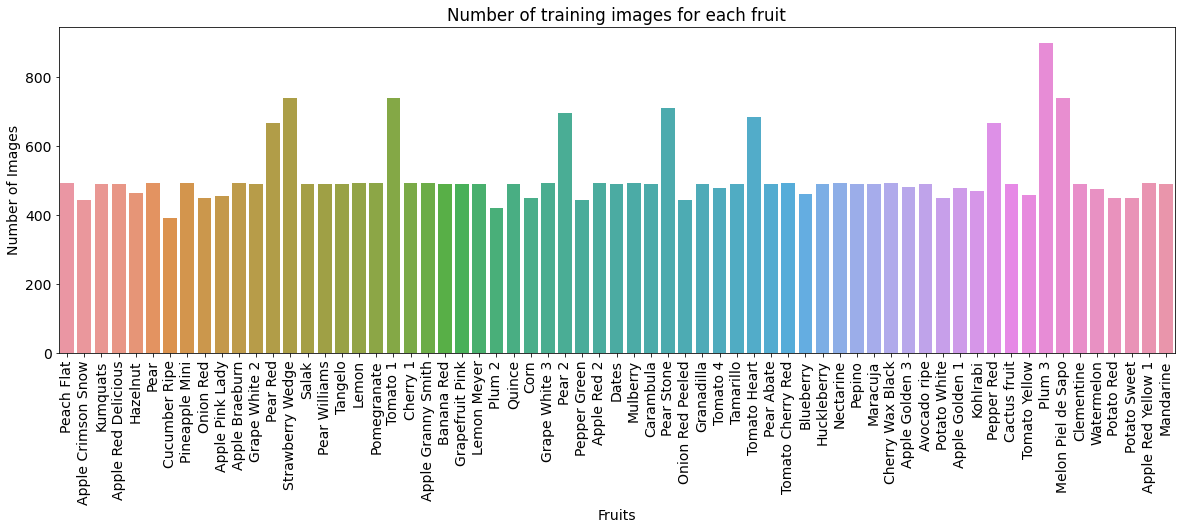

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.barplot(x=classes[:65],y=count[:65])
plt.xticks(rotation=90)
plt.xlabel('Frutti')
plt.ylabel('Num immagini')
plt.title('Num delle immagini Training per ogni categoria')

plt.show()

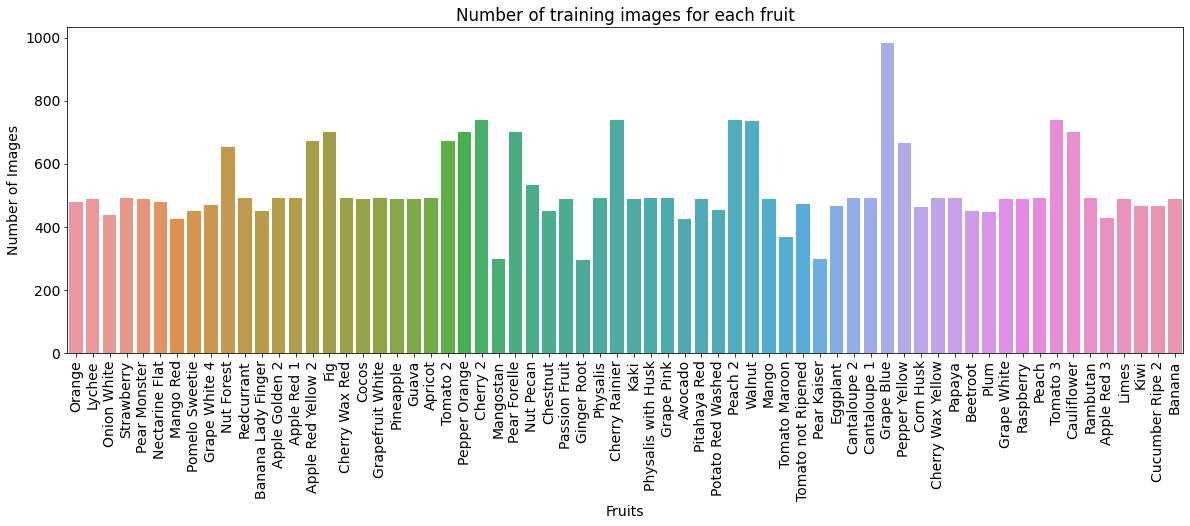

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.barplot(x=classes[65:],y=count[65:])
plt.xticks(rotation=90)
plt.xlabel('Frutti')
plt.ylabel('Num immagini')
plt.title('Num delle immagini Training per ogni categoria')

plt.show()

### Aspetto originale delle immagini 

In [ ]:
dataset = ImageFolder(train_directory, transform=ToTensor())

Esempio di un singolo elemento del dataset. \
Abbiamo una "tuple", che contiene l'immagine (tensore) e una label. Dato che l'immagine ha 100x100 pixel e i 3 canali RGB, la shape sarà (3,100,100)



In [ ]:
img, label = dataset[0]
print('img_shape:', img.shape)
print('Label:', label)
img

img_shape: torch.Size([3, 100, 100])
Label: 0


tensor([[[0.9961, 0.9961, 0.9961,  ..., 1.0000, 1.0000, 1.0000],
         [0.9961, 0.9961, 0.9961,  ..., 1.0000, 1.0000, 1.0000],
         [0.9961, 0.9961, 0.9961,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.

In [ ]:
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  Apple Braeburn (0)


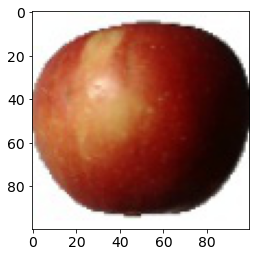

In [ ]:
show_example(*dataset[1])

Label:  Lemon (59)


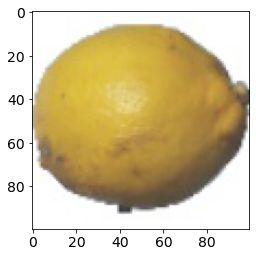

In [ ]:
show_example(*dataset[2134])

Label:  Raspberry (113)


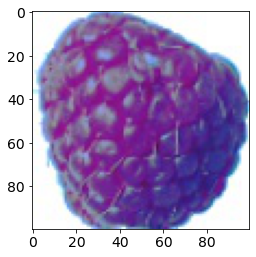

In [ ]:
show_example(*dataset[32865])

##Data Augmentation-Normalizzazione, Dataloader e aspetto delle immagini trasformate

Dataloadet finalizzato al data augmentation e alla normalizzazione. La batchsize scelta è 64.

In [ ]:
data_loader = DataLoader(dataset, 64)

Creo una funzione per calcolare media e dev. standard dal dataloader che servirà per la normalizzazione e per il data augmentation.

In [ ]:
def get_mean_sd(loader):
  channel_sum, channel_squared_sum, num_batches = 0, 0, 0
  for image, _ in loader:
    channel_sum += torch.mean(image, dim=[0,2,3])
    channel_squared_sum += torch.mean(image**2, dim=[0,2,3])
    num_batches += 1
  
  mean = channel_sum / num_batches
  sd = (channel_squared_sum / num_batches - mean**2)**0.5

  return mean, sd

In [ ]:
mean, sd = get_mean_sd(data_loader)
print(mean)
print(sd)

tensor([0.6840, 0.5786, 0.5037])
tensor([0.3035, 0.3600, 0.3914])


Sequenza delle trasformazioni sulle immagini (norm e data_augm)

In [ ]:
image_size = 32
stats = ((0.6840, 0.5786, 0.5037), (0.3035, 0.3600, 0.3914))
train_tfms = tt.Compose([tt.Resize((image_size, image_size)),
                         tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                         # tt.RandomRotate
                         # tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                         # tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                         tt.ToTensor()])
                         #,tt.Normalize(*stats,inplace=True)])
val_tfms = tt.Compose([tt.Resize((image_size, image_size)),
                       tt.ToTensor()])
                       #,tt.Normalize(*stats)])

Applico le trasformazioni al dataset di Training e a quello di Test. (Uso la classe ImageFolder di Torchvision).


In [ ]:
train_ds = ImageFolder(train_directory, train_tfms)
val_ds = ImageFolder(val_directory, val_tfms)

Dataloader definitivo sul dataset appena trasformato (batchsize=128). 

In [ ]:
batch_size = 128
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=3, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Come appaiono le immagini di una batch? Devo de-normalizzare i pixel per riportarli nell'intervallo (0,1) 

In [ ]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        #denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


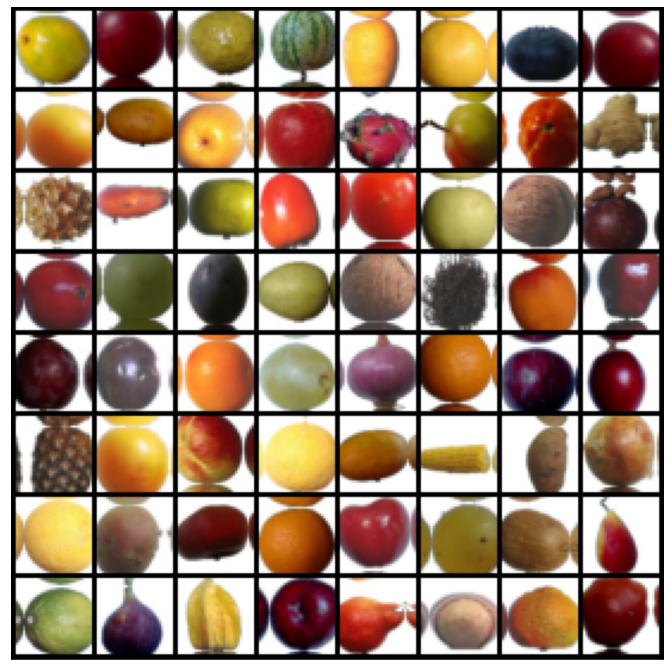

In [ ]:
show_batch(train_loader)

Osservazioni: 
1) I colori hanno dei difetti: ciò è dovuto alla normalizzazione. \
2) Si nota l'effetto di "cropping" e "reflection padding" in qualche immagine.\
 C'è anche l'horizontal flip ma chiaramente non si vede bene.

## Uso della GPU

Per richiamare la GPU definisco due "helper functions" (get_default_device & to_device) e una "helper class" (DeviceDataLoader) per spostare il modello e i dati sulla GPU.

In [ ]:
def get_default_device():   #Scegli la GPU, altrimenti la CPU
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):     #Muovi i tensori sul device disponibile
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():  #Wrapping del dataloadr per muovere i dati sul device
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):  #Restituire una batch di dati dopo averla spostata sul device
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):    #Num. di batches
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

Ora faccio il wrapping dei dataloader di training e testing usando la funzione DeviceDataLoader per trasferire automaticamente le batches sulla GPU.

In [ ]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [ ]:
for img, _ in train_loader:
  print(img.shape)
  break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([128, 3, 32, 32])


Chiaramente dopo il resizing, le immagini sono a 32x32 pixel. 

## Modello e architettura




Definisco le classiche operazioni all'interno del modello.

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class FruitsImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Genero la predizione
        loss = F.cross_entropy(out, labels) # Calcolo la loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Genero la predizione
        loss = F.cross_entropy(out, labels)   # Calcolo la loss
        acc = accuracy(out, labels)           # Calcolo la accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combino le loss
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combino le accuracy
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

Sviluppo il modello ResNet-like. La funzione conv_block utilizza i layer della rete neurale convoluzionale, che è l'elemento costitutivo dell'architettura ResNet. Inoltre, dopo ogni livello convoluzionale, aggiungo un livello di normalizzazione batch, che normalizza le uscite del livello precedente. Anche l'aggiunta del blocco residuo produce un miglioramento significativo delle prestazioni del modello.



In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class FruitsResNet9(FruitsImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)    # output: 128 x 16 x 16
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)   # output: 256 x 8 x 8
        self.conv4 = conv_block(256, 512, pool=True)   # output: 512 x 4 x 4
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4),    # output: 512 x 1 x 1
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [ ]:
model = to_device(FruitsResNet9(3, 131), device)
model;

## Funzione di training

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Imposto un optimizer customizzato con weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Imposto lo scheduler del learning rate a ciclo unico
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Fase di training
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Clipping del gradiente 
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record e aggiornamento del learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Fase di validazione
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Prima di proseguire con il training, valuto il modello non allenato.



In [ ]:
history = [evaluate(model, val_loader)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.01027036551386118, 'val_loss': 4.874704360961914}]

## Training


In [ ]:
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], last_lr: 0.00279, train_loss: 0.7298, val_loss: 0.4083, val_acc: 0.8803
Epoch [1], last_lr: 0.00760, train_loss: 0.2603, val_loss: 0.4193, val_acc: 0.8946
Epoch [2], last_lr: 0.01000, train_loss: 0.1252, val_loss: 0.2771, val_acc: 0.9115
Epoch [3], last_lr: 0.00950, train_loss: 0.0894, val_loss: 0.0947, val_acc: 0.9750
Epoch [4], last_lr: 0.00812, train_loss: 0.0749, val_loss: 0.3083, val_acc: 0.9023
Epoch [5], last_lr: 0.00611, train_loss: 0.0590, val_loss: 0.1301, val_acc: 0.9697
Epoch [6], last_lr: 0.00389, train_loss: 0.0321, val_loss: 0.0588, val_acc: 0.9810
Epoch [7], last_lr: 0.00188, train_loss: 0.0166, val_loss: 0.0192, val_acc: 0.9943
Epoch [8], last_lr: 0.00050, train_loss: 0.0023, val_loss: 0.0115, val_acc: 0.9974
Epoch [9], last_lr: 0.00000, train_loss: 0.0010, val_loss: 0.0105, val_acc: 0.9978
CPU times: user 1min 42s, sys: 11.4 s, total: 1min 54s
Wall time: 9min 45s


In [ ]:
train_time = '9:45'

In [ ]:
result = evaluate(model, val_loader)
result

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'val_acc': 0.997761607170105, 'val_loss': 0.010495305992662907}

Il modello raggiunge un accuracy circa del 100%. Questo è dovuto a: \
1)il grande numero di di immagini nel dataset \
2)le operazioni di data trasformation e data augmentation hanno permesso di generalizzare i dati.

## Accuracy del modello e plot della loss 

Plot della accuracy al passare del tempo, per vedere come il modello migliora passo passo. 

In [ ]:
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (9, 5)
matplotlib.rcParams['figure.facecolor'] = '#00000000'
sns.set_style('darkgrid')

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-bx')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

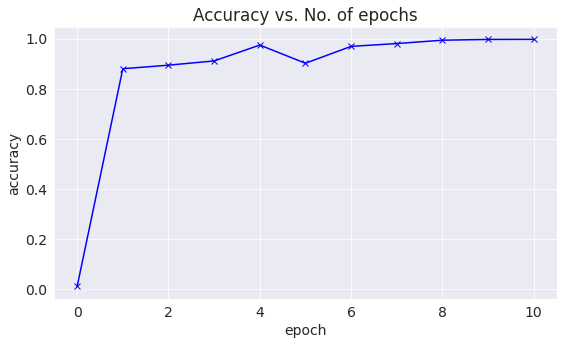

In [ ]:
plot_accuracies(history)

Plot della training loss e della validation loss.

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

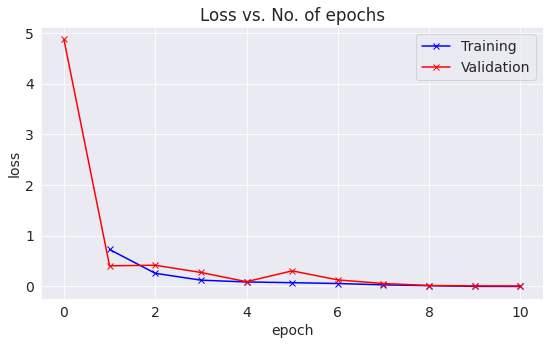

In [ ]:
plot_losses(history)

Dal grafico si nota che  le due loss seguono lo stesso andamento e l'overfitting è stato scongiurato durante l'apprendimento.

Possiamo anche mostrare come cambia il learning rate al passare del tempo, batch per batch su tutte le epoch. 

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs, 'b') 
    plt.xlabel('Batch No.')
    plt.ylabel('One Cycle Learning Rate Scheduler')
    plt.title('One Cycle Learning Rate Scheduler vs. Batch No.');

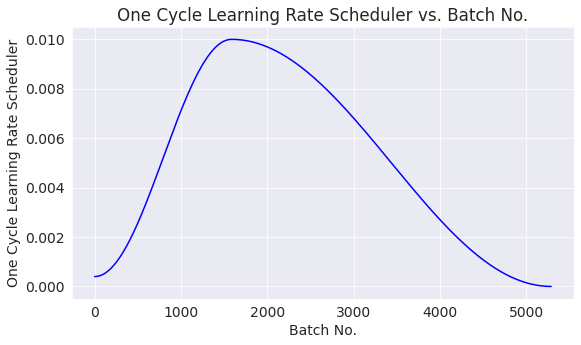

In [ ]:
plot_lrs(history)

## Test con singole immagini

Definisco una funzione per il test sulle singole immagini.

In [ ]:
def predict_image(img, model):
    # Converto ad un batch di 1
    xb = to_device(img.unsqueeze(0), device)
    # Predizione del modello
    yb = model(xb)
    # Prendi l'indece relativo alla probabilità più alta
    _, preds  = torch.max(yb, dim=1)
    # Trattieni la label
    return train_ds.classes[preds[0].item()]

Label: Apple Braeburn , Predicted: Apple Braeburn


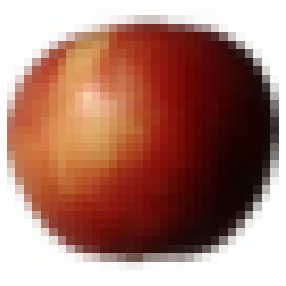

In [ ]:
img, label = val_ds[0]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
plt.axis('off')
print('Label:', val_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: Apple Red Yellow 1 , Predicted: Apple Red Yellow 1


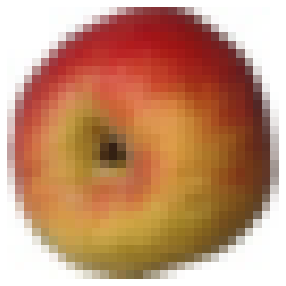

In [ ]:
img, label = val_ds[1851]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
plt.axis('off')
print('Label:', val_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: Plum , Predicted: Plum


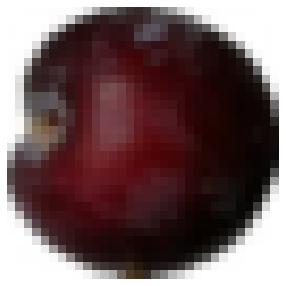

In [ ]:
img, label = val_ds[17644]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
plt.axis('off')
print('Label:', val_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: Mango , Predicted: Mango


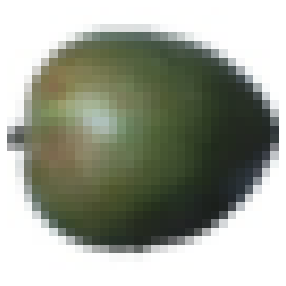

In [ ]:
img, label = val_ds[10865]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
plt.axis('off')
print('Label:', val_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: Watermelon , Predicted: Watermelon


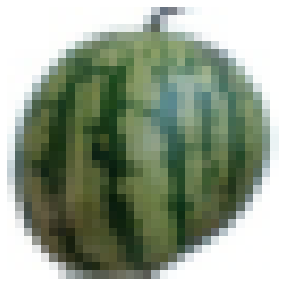

In [ ]:
img, label = val_ds[22578]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
plt.axis('off')
print('Label:', val_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: Orange , Predicted: Orange


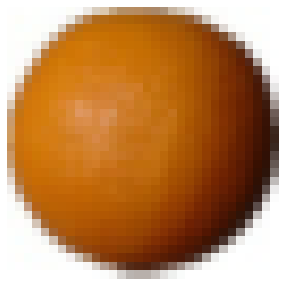

In [ ]:
img, label = val_ds[12999]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
plt.axis('off')
print('Label:', val_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: Tamarillo , Predicted: Tamarillo


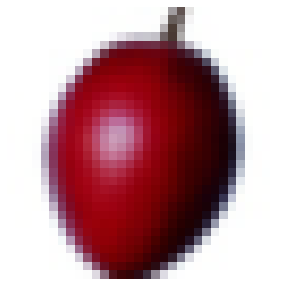

In [ ]:
img, label = val_ds[20320]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
plt.axis('off')
print('Label:', val_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: Strawberry , Predicted: Strawberry


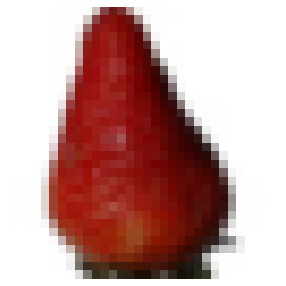

In [ ]:
img, label = val_ds[19876]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
plt.axis('off')
print('Label:', val_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: Banana , Predicted: Banana


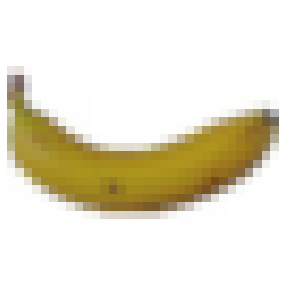

In [ ]:
img, label = val_ds[2688]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
plt.axis('off')
print('Label:', val_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: Tomato 3 , Predicted: Tomato 3


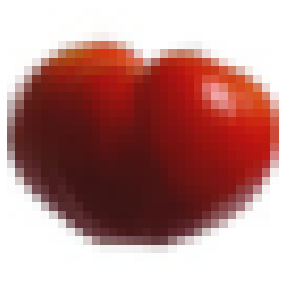

In [ ]:
img, label = val_ds[21098]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
plt.axis('off')
print('Label:', val_ds.classes[label], ', Predicted:', predict_image(img, model))